In [1]:
import os
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import kornia as K
import kornia.feature as KF
import preprocessing
import validation
import plotting
import warnings
warnings.filterwarnings("ignore")

input_dir = '../../data/train/' # directory of the training data

/Users/Dieter/Documents/Data Science/neuefische/capstone-project-image-matching-challenge/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [319]:
# REMOVE LATER
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# for use with MacBooks
# pip install torch

# for use with AMD GPUs on Linux
# pip3 install torch --extra-index-url https://download.pytorch.org/whl/rocm5.1.1

In [3]:
# Load all scene names from the training data
all_scenes = preprocessing.get_scenes(input_dir)
all_scenes 

['brandenburg_gate',
 'british_museum',
 'buckingham_palace',
 'colosseum_exterior',
 'grand_place_brussels',
 'lincoln_memorial_statue',
 'notre_dame_front_facade',
 'pantheon_exterior',
 'piazza_san_marco',
 'sacre_coeur',
 'sagrada_familia',
 'st_pauls_cathedral',
 'st_peters_square',
 'taj_mahal',
 'temple_nara_japan',
 'trevi_fountain']

In [411]:
# Load all image pairs, along with their covisibility and fundamental matrix

#scenes = all_scenes # load all scenes
scenes = [all_scenes[1]] # load only the first scene

pairs = preprocessing.load_pairs(scenes,input_dir)

# Load either all pairs, or only withing a specific covisibility range
#pairs = pairs.reset_index()
#pairs = pairs.query('covisibility > 0.95').reset_index()
pairs = pairs.query('0.6 < covisibility < 0.8').reset_index()

pairs

loading category 1 of 1: british_museum


,index,pair,covisibility,fundamental_matrix,scene
0,5,95405900_917617676-93658023_4980549800,0.712,3.61637413e-02 8.35751020e+00 -4.53560370e+03 ...,british_museum
1,6,94345807_4553191473-84932226_4352179060,0.718,-3.17511774e-02 2.02240785e+00 -1.26519331e+03...,british_museum
2,7,93658023_4980549800-92199010_423632152,0.722,-4.43040722e-02 -1.88988338e+00 1.09814056e+03...,british_museum
3,8,93658023_4980549800-78242267_4404579754,0.729,6.81232730e-04 -5.44813051e+00 3.06535780e+03 ...,british_museum
4,10,93658023_4980549800-73839172_5084383337,0.747,-1.05066064e-01 -3.13343952e+00 1.79690171e+03...,british_museum
...,...,...,...,...,...
602,610,67471600_1224757581-53631371_144323144,0.601,2.11797237e-02 -2.45258981e-01 -1.69098337e+01...,british_museum
603,611,67471600_1224757581-53881364_5029031037,0.617,-1.50226483e-02 -1.72602117e+00 9.32229212e+02...,british_museum
604,612,67471600_1224757581-57504314_2114264842,0.615,-2.91867523e-02 4.18921365e+00 -3.09025358e+03...,british_museum
605,613,67471600_1224757581-66393650_5300086486,0.672,7.34230966e-02 1.75072163e+00 -1.22313831e+03 ...,british_museum


In [356]:
# Determine if a GPU is available, otherwise use CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [369]:
# Initialize LoFTR and load the outdoor weights
matcher = KF.LoFTR(pretrained='outdoor')
matcher = matcher.to(device).eval()

In [415]:
# Run LoFTR on the image pairs loaded previously. The output is a DataFrame containing all relevant data for each image pair analyzed.
scene_list = []
fund_matrix_list = []
pair_list = []
fund_matrix_eval = []
pair_eval = []
mkpts0_list = []
mkpts1_list = []
mconf_list = []

for index, row in pairs.head(20).iterrows(): # Head controls how many image pairs are analyzed
    
    split_pair = pairs.pair[index].split('-')
    img_id0 = split_pair[0]
    img_id1 = split_pair[1]
    
    img0_pth = os.path.join(input_dir, pairs.scene[index], "images", str(img_id0 + '.jpg'))
    img1_pth = os.path.join(input_dir, pairs.scene[index], "images", str(img_id1 + '.jpg'))
    img0 = preprocessing.load_torch_image(img0_pth, device)
    img1 = preprocessing.load_torch_image(img1_pth, device)
    batch = {"image0": K.color.rgb_to_grayscale(img0), 
            "image1": K.color.rgb_to_grayscale(img1)}
    
    with torch.no_grad():
        matcher(batch)
        mkpts0 = batch['mkpts0_f'].cpu().numpy()
        mkpts1 = batch['mkpts1_f'].cpu().numpy()
        mconf = batch['mconf'].cpu().numpy()
        
    F = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.2, 0.99999, 50000)
    
    scene_list.append(pairs.scene[index])
    fund_matrix_list.append(F[0])
    pair_list.append(pairs.pair[index])
    fund_matrix_eval.append(" ".join(str(num) for num in F[0].flatten().tolist()))
    pair_eval.append(";".join(["phototourism",pairs.scene[index],pairs.pair[index]]))
    mkpts0_list.append(mkpts0)
    mkpts1_list.append(mkpts1)
    mconf_list.append(mconf)
    
results = pd.DataFrame({'scene': scene_list, 'pair': pair_list, 'fund_matrix': fund_matrix_list, 
                        'mkpts0': mkpts0_list, 'mkpts1': mkpts1_list, 'mconf': mconf_list,
                        'pair_eval': pair_eval, 'fund_matrix_eval': fund_matrix_eval}) 

In [416]:
results

,scene,pair,fund_matrix,mkpts0,mkpts1,mconf,pair_eval,fund_matrix_eval
0,british_museum,95405900_917617676-93658023_4980549800,"[[4.361307553069802e-09, 1.029872564349701e-05...","[[589.86536, 15.942307], [526.0961, 23.913462]...","[[565.9515, 48.136402], [502.19498, 56.050385]...","[0.41044125, 0.22606952, 0.30164278, 0.3456607...",phototourism;british_museum;95405900_917617676...,4.361307553069802e-09 1.029872564349701e-05 -0...
1,british_museum,94345807_4553191473-84932226_4352179060,"[[2.102133714415874e-08, -1.8257250978251812e-...","[[215.74039, 15.980769], [223.73077, 15.980769...","[[317.34018, 60.620064], [324.83658, 61.57281]...","[0.22566484, 0.83025485, 0.776704, 0.68048805,...",phototourism;british_museum;94345807_455319147...,2.102133714415874e-08 -1.8257250978251812e-06 ...
2,british_museum,93658023_4980549800-92199010_423632152,"[[-5.6165568625799e-08, -2.1551432020313548e-0...","[[568.0, 48.0], [528.0, 56.0], [536.0, 56.0], ...","[[519.87573, 56.24771], [473.16208, 71.58705],...","[0.5443971, 0.47787657, 0.47587308, 0.30500925...",phototourism;british_museum;93658023_498054980...,-5.6165568625799e-08 -2.1551432020313548e-06 0...
3,british_museum,93658023_4980549800-78242267_4404579754,"[[4.276039320724183e-10, -5.011886678449733e-0...","[[560.0, 32.0], [560.0, 40.0], [568.0, 48.0], ...","[[569.7016, 22.765049], [570.025, 33.06838], [...","[0.38476494, 0.2709797, 0.41336477, 0.27564225...",phototourism;british_museum;93658023_498054980...,4.276039320724183e-10 -5.011886678449733e-06 0...
4,british_museum,93658023_4980549800-73839172_5084383337,"[[2.637976595299585e-07, 7.582588371880025e-06...","[[560.0, 24.0], [568.0, 24.0], [560.0, 32.0], ...","[[557.5099, 86.34533], [566.4447, 85.82347], [...","[0.5341574, 0.38648623, 0.7978504, 0.7320956, ...",phototourism;british_museum;93658023_498054980...,2.637976595299585e-07 7.582588371880025e-06 -0...
5,british_museum,93658023_4980549800-71902171_5360301587,"[[-7.911168567467832e-08, -5.799554952054176e-...","[[560.0, 24.0], [560.0, 32.0], [568.0, 32.0], ...","[[534.3567, 33.321297], [534.5141, 42.363228],...","[0.3192172, 0.31035563, 0.48226547, 0.46959293...",phototourism;british_museum;93658023_498054980...,-7.911168567467832e-08 -5.799554952054176e-06 ...
6,british_museum,93658023_4980549800-69960354_6519615529,"[[2.9103123499936214e-07, 7.642907056909084e-0...","[[552.0, 24.0], [560.0, 24.0], [568.0, 24.0], ...","[[640.20135, 15.146628], [647.9796, 13.053014]...","[0.21312691, 0.51420665, 0.39295945, 0.8696967...",phototourism;british_museum;93658023_498054980...,2.9103123499936214e-07 7.642907056909084e-06 -...
7,british_museum,93658023_4980549800-32520806_97760578,"[[2.8823447454216885e-09, 9.401079480313302e-0...","[[536.0, 48.0], [568.0, 48.0], [584.0, 48.0], ...","[[520.77686, 102.40434], [553.1919, 101.1971],...","[0.27727136, 0.27321145, 0.20655614, 0.2110498...",phototourism;british_museum;93658023_498054980...,2.8823447454216885e-09 9.401079480313302e-06 -...
8,british_museum,93658023_4980549800-07041504_41859620,"[[1.5275172157078748e-07, 7.716077106807249e-0...","[[544.0, 48.0], [552.0, 48.0], [560.0, 48.0], ...","[[546.0492, 105.02864], [558.52356, 105.27583]...","[0.25294933, 0.4725911, 0.26532376, 0.27992246...",phototourism;british_museum;93658023_498054980...,1.5275172157078748e-07 7.716077106807249e-06 -...
9,british_museum,93658023_4980549800-02724900_7322693146,"[[1.0189796580061317e-07, 2.274294259942207e-0...","[[552.0, 24.0], [560.0, 24.0], [568.0, 24.0], ...","[[576.9624, 17.870983], [583.94037, 17.735136]...","[0.22127134, 0.75616014, 0.7340489, 0.20238589...",phototourism;british_museum;93658023_498054980...,1.0189796580061317e-07 2.274294259942207e-06 -...


In [417]:
# Run the validation on all results and return the mean average accuracy
maa = validation.evaluate(input_dir, results.pair_eval, results.fund_matrix_eval)
print(f'mAA={maa} (n={len(results)})')

mAA=0.5700000000000001 (n=20)


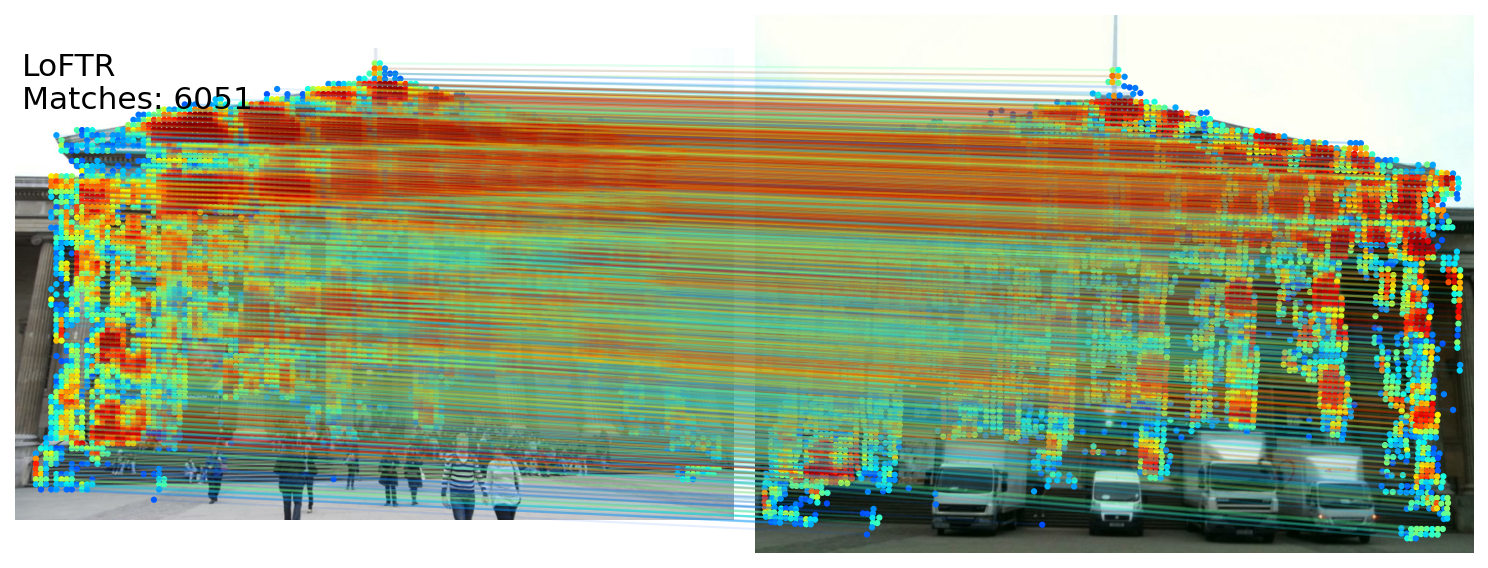

In [482]:
# Draw matches for a single pair from the results

index = 4 # select image pair from results DataFrame
threshold = 0 # setting a confidence threshold (0 == no threshold)

df_draw = pd.DataFrame({'mkpts0': results.mkpts0[index].tolist(), 'mkpts1': results.mkpts1[index].tolist(), 'mconf': results.mconf[index].tolist()})

img0_pth = os.path.join(input_dir, results.scene[index], "images", str(results.pair[index].split('-')[0] + '.jpg'))
img1_pth = os.path.join(input_dir, results.scene[index], "images", str(results.pair[index].split('-')[1] + '.jpg'))
img0 = preprocessing.load_image(img0_pth)
img1 = preprocessing.load_image(img1_pth)

color = cm.jet(df_draw.query(f'mconf > {threshold}').mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(df_draw.query(f'mconf > {threshold}')))]
fig = plotting.make_matching_figure(img0, img1, np.array(df_draw.query(f'mconf > {threshold}').mkpts0.values.tolist()), 
                                    np.array(df_draw.query(f'mconf > {threshold}').mkpts1.values.tolist()), color, text=text, dpi=150, alpha = 0.1, lines = True)

In [483]:
F = cv2.findFundamentalMat(np.array(df_draw.query(f'mconf > {threshold}').mkpts0.values.tolist()), np.array(df_draw.query(f'mconf > {threshold}').mkpts1.values.tolist()), cv2.USAC_MAGSAC, 0.2, 0.99999, 50000)
single_evaluate_scene = results.scene[index]
single_evaluate_pair = results.pair[index]
single_evaluate_pair_eval = results.pair_eval[index]
aa = validation.evaluate_single(input_dir, single_evaluate_pair_eval, " ".join(str(num) for num in F[0].flatten().tolist()))
print(f'Accuracy = {aa[0]}\nAngle error (degrees) = {aa[1][single_evaluate_scene][single_evaluate_pair]}\nDistance error (meters) = {aa[2][single_evaluate_scene][single_evaluate_pair]}')

Accuracy = 0.6
Angle error (degrees) = 1.008302168828006
Distance error (meters) = 0.7954531179639229


### Plotting with Plotly instead of Matplotlib

Plotly can also be used to plot the matches, however lines can't be shown.

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
# Draw matches for a single pair from the results with plotly (lines do not work)

index = 1 # select image pair from results DataFrame
threshold = 0 # setting a confidence threshold (0 == no threshold)

df_draw = pd.DataFrame({'mkpts0': results.mkpts0[index].tolist(), 'mkpts1': results.mkpts1[index].tolist(), 'mconf': results.mconf[index].tolist()})

img0_pth = os.path.join(input_dir, results.scene[index], "images", str(results.pair[index].split('-')[0] + '.jpg'))
img1_pth = os.path.join(input_dir, results.scene[index], "images", str(results.pair[index].split('-')[1] + '.jpg'))
img0 = preprocessing.load_image(img0_pth)
img1 = preprocessing.load_image(img1_pth)

color = cm.jet(df_draw.query(f'mconf > {threshold}').mconf)
color_trans = color * np.full(color.shape,255)
color_trans = np.delete(color_trans, -1, axis=1)
color_plotly = [f'rgb({",".join(c)})' for c in color_trans.astype(str)]
text = [
    'LoFTR',
    'Matches: {}'.format(len(df_draw.query(f'mconf > {threshold}')))]
fig = plotting.make_matching_figure_plotly(img0, img1, np.array(df_draw.query(f'mconf > {threshold}').mkpts0.values.tolist()), 
                                    np.array(df_draw.query(f'mconf > {threshold}').mkpts1.values.tolist()), color_plotly, text=text, alpha = 0.1)
fig

### Outlier removal using DBSCAN

In [491]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

In [493]:
X = results.mkpts0[index]
X_conf = results.mconf[index]
X_conf_reshaped = np.reshape(X_conf, (len(X), 1))
X_concat = np.append(X, X_conf_reshaped, axis = 1)

In [494]:
scaler = MinMaxScaler()
X_concat_scaled = scaler.fit_transform(X_new)

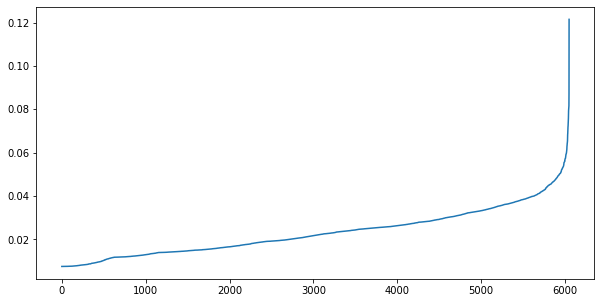

In [495]:
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=5).fit(X_concat_scaled)
distances, idx = nn.kneighbors(X_concat_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

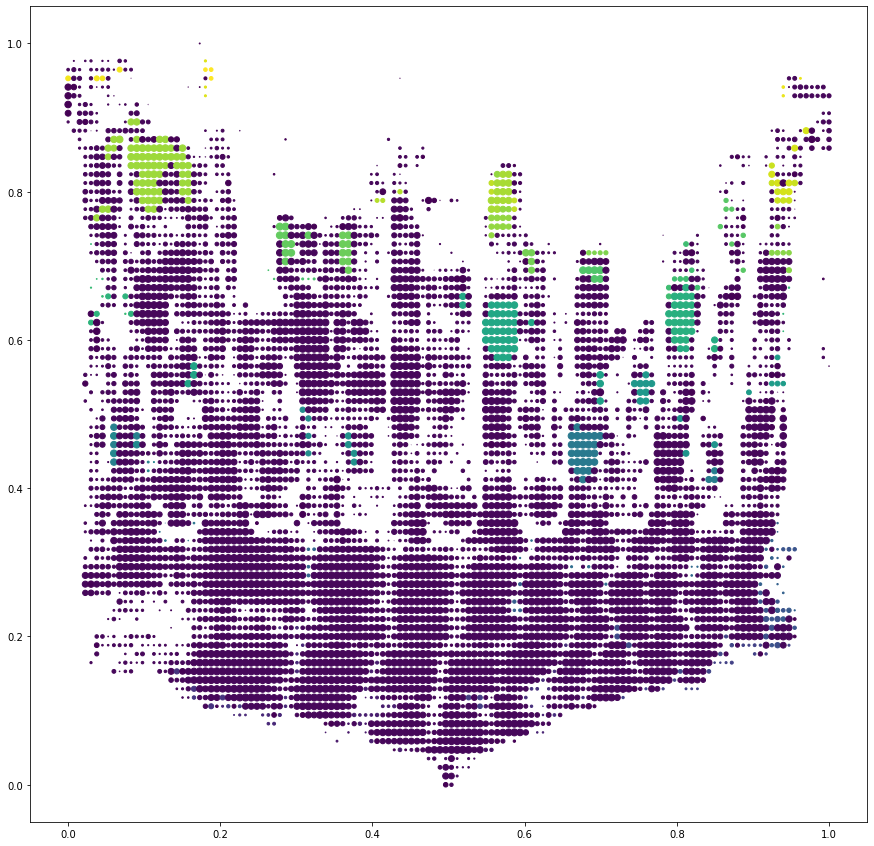

In [499]:
clustering = DBSCAN(eps=0.05, min_samples=3).fit(X_concat_scaled)
plt.figure(figsize=(15,15))
plt.scatter(X_concat_scaled[:, 0], X_concat_scaled[:, 1], c = clustering.labels_, s = X_concat_scaled[:,2]*50)

In [500]:
df_draw['clustering_labels'] = clustering.labels_

F = cv2.findFundamentalMat(np.array(df_draw.query(f'clustering_labels != -1').mkpts0.values.tolist()), np.array(df_draw.query(f'clustering_labels != -1').mkpts1.values.tolist()), cv2.USAC_MAGSAC, 0.2, 0.99999, 50000)
single_evaluate_scene = results.scene[index]
single_evaluate_pair = results.pair[index]
single_evaluate_pair_eval = results.pair_eval[index]
aa = validation.evaluate_single(input_dir, single_evaluate_pair_eval, " ".join(str(num) for num in F[0].flatten().tolist()))
print(f'Accuracy = {aa[0]}\nAngle error (degrees) = {aa[1][single_evaluate_scene][single_evaluate_pair]}\nDistance error (meters) = {aa[2][single_evaluate_scene][single_evaluate_pair]}')

Accuracy = 0.6
Angle error (degrees) = 1.0315667142448608
Distance error (meters) = 0.8157731355509144
